In [1]:
import os
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.ticker import AutoMinorLocator
%matplotlib inline

from fbprophet import Prophet

Importing plotly failed. Interactive plots will not work.


## Load Datasets

In [15]:
# prepare the TREB home price reference dataset starts at 2012-02
# extracted data from pdfs is prepared in master csv for usage in the study
housing_price_df = pd.read_csv('/data/treb_home_price_reference_master/TREB_Home_Price_Reference_2012Feb_2016Oct.csv')

In [16]:
# set datetime index
housing_price_df['Date'] = pd.to_datetime(housing_price_df['Date'])
housing_price_df = housing_price_df.set_index('Date').sort_index()

In [17]:
# set columns to numeric
for col in value_names:
    housing_price_df[col] = pd.to_numeric(housing_price_df[col])

In [18]:
# linearly interpolate missing records from pdf to csv conversion
housing_price_df = housing_price_df.interpolate(method='time')

In [19]:
# extract only housing reference price columns for analysis later - leave out the housing indices
reference_price_cols = [x for x in housing_price_df.columns if x.find('Reference') !=-1]

In [20]:
# prepare the housing construction data from 2012-02

construction_df = pd.read_csv('/data/construction/3410015301_databaseLoadingData_housing_construction.csv',
                             usecols = ['REF_DATE','GEO','VALUE'])

construction_df = construction_df[construction_df['GEO']=='Toronto, Ontario'].drop('GEO',axis=1).\
                                                                             rename(columns={'REF_DATE':'Date','VALUE':'HousingConstruction'})
construction_df['Date'] = pd.to_datetime(construction_df['Date'])
construction_df = construction_df.set_index('Date').sort_index()['2012-02':]

In [21]:
# prepare the employment data by immigration status (Landed immigrant and Born in Canada (bic)) from 2012-02

employment_df = pd.read_csv('/data/employment/1410008201_databaseLoadingData_toronto_employment_immigration_25-54_years.csv',
                           usecols = ['REF_DATE','Immigrant status','VALUE'])

employment_immigrant_df = employment_df[employment_df['Immigrant status']=='Landed immigrants'].drop('Immigrant status', axis=1).\
                                    rename(columns = {'REF_DATE':'Date','VALUE':'ImmigrantEmployment'})
employment_immigrant_df['ImmigrantEmployment'] = employment_immigrant_df['ImmigrantEmployment']*1000
employment_immigrant_df['Date'] = pd.to_datetime(employment_immigrant_df['Date'])
employment_immigrant_df = employment_immigrant_df.set_index('Date').sort_index()['2012-02':]

employment_bic_df = employment_df[employment_df['Immigrant status']=='Born in Canada'].drop('Immigrant status', axis=1).\
                                    rename(columns = {'REF_DATE':'Date','VALUE':'BicEmployment'})
employment_bic_df['BicEmployment'] = employment_bic_df['BicEmployment']*1000
employment_bic_df['Date'] = pd.to_datetime(employment_bic_df['Date'])
employment_bic_df = employment_bic_df.set_index('Date').sort_index()['2012-02':]

In [22]:
# prepare financial rate data from 2012-02

financial_df = pd.read_csv('/data/mortgage/1010014501_databaseLoadingData_bank_rates.csv',
                          usecols = ['REF_DATE','Rates','VALUE'])

financial_prime_df = financial_df[financial_df['Rates']=='Chartered bank administered interest rates - Prime rate'].drop('Rates', axis=1).\
                                    rename(columns = {'REF_DATE':'Date','VALUE':'PrimeRate'})
financial_prime_df['Date'] = pd.to_datetime(financial_prime_df['Date'])
financial_prime_df = financial_prime_df.set_index('Date')
financial_prime_df = financial_prime_df.resample('M').mean().sort_index()['2012-02':]

financial_mortgage_df = financial_df[financial_df['Rates']=='Chartered bank - conventional mortgage: 5 year'].drop('Rates', axis=1).\
                                    rename(columns = {'REF_DATE':'Date','VALUE':'MortgageRate'})
financial_mortgage_df['Date'] = pd.to_datetime(financial_mortgage_df['Date'])
financial_mortage_df = financial_mortgage_df.set_index('Date')
financial_mortage_df = financial_mortage_df.resample('M').mean().sort_index()['2012-02':]

In [23]:
# prepare mortgage lending data from 2012-02

mortgage_df = pd.read_csv('/data/mortgage/1010000601_databaseLoadingData_mortgage_loans.csv',
                          usecols = ['REF_DATE','Components','VALUE'])

mortgage_insured_df = mortgage_df[mortgage_df['Components']=='Total, funds advanced, residential mortgages, insured'].drop('Components', axis=1).\
                                    rename(columns = {'REF_DATE':'Date','VALUE':'InsuredLending'})
mortgage_insured_df['Date'] = pd.to_datetime(mortgage_insured_df['Date'])
mortgage_insured_df['InsuredLending'] = mortgage_insured_df['InsuredLending']*1000000
mortgage_insured_df = mortgage_insured_df.set_index('Date').sort_index()['2012-02':]

mortgage_uninsured_df = mortgage_df[mortgage_df['Components']=='Total, funds advanced, residential mortgages, uninsured'].drop('Components', axis=1).\
                                    rename(columns = {'REF_DATE':'Date','VALUE':'UninsuredLending'})
mortgage_uninsured_df['Date'] = pd.to_datetime(mortgage_uninsured_df['Date'])
mortgage_uninsured_df['UninsuredLending'] = mortgage_uninsured_df['UninsuredLending']*1000000
mortgage_uninsured_df = mortgage_uninsured_df.set_index('Date').sort_index()['2012-02':]

In [24]:
# prepare wages data

wages_df = pd.read_csv('/data/wages/3610020501_databaseLoadingData_wages.csv',
                          usecols = ['REF_DATE','Sector','VALUE'])

wages_df = wages_df[wages_df['Sector']=='Wages and salaries'].drop('Sector', axis=1).\
                                    rename(columns = {'REF_DATE':'Date','VALUE':'Wages'})
wages_df['Date'] = pd.to_datetime(wages_df['Date'])
wages_df['Wages'] = wages_df['Wages']*1000
wages_df = wages_df.set_index('Date').sort_index()['2012-02':]

### Analysis of Datasets

Text(0, 0.5, 'Reference Prices')

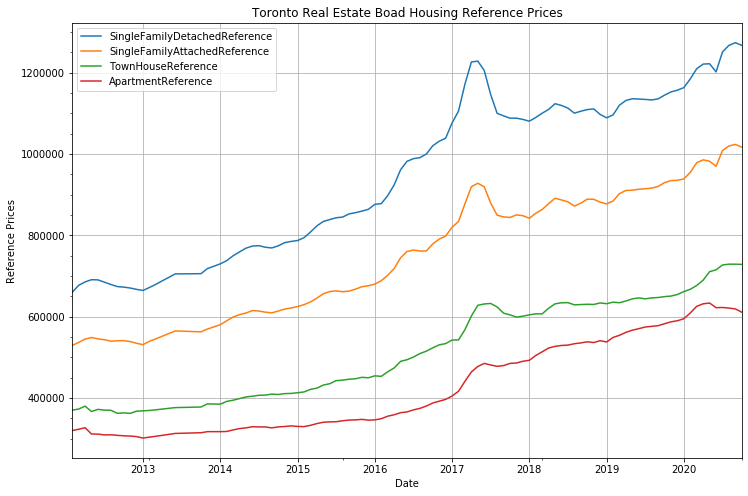

In [25]:
# plot housing reference prices
ax = housing_price_df[reference_price_cols].plot(figsize=(12,8), grid=True, title='Toronto Real Estate Boad Housing Reference Prices')
ax.xaxis.set_minor_locator(mdates.MonthLocator(interval=1))
ax.yaxis.set_minor_locator(AutoMinorLocator())
plt.ylabel('Reference Prices')

Text(0.5, 1, 'Toronto house prices, finanical rates, housing construction, employment, mortgage lending, wages series from February 2012')

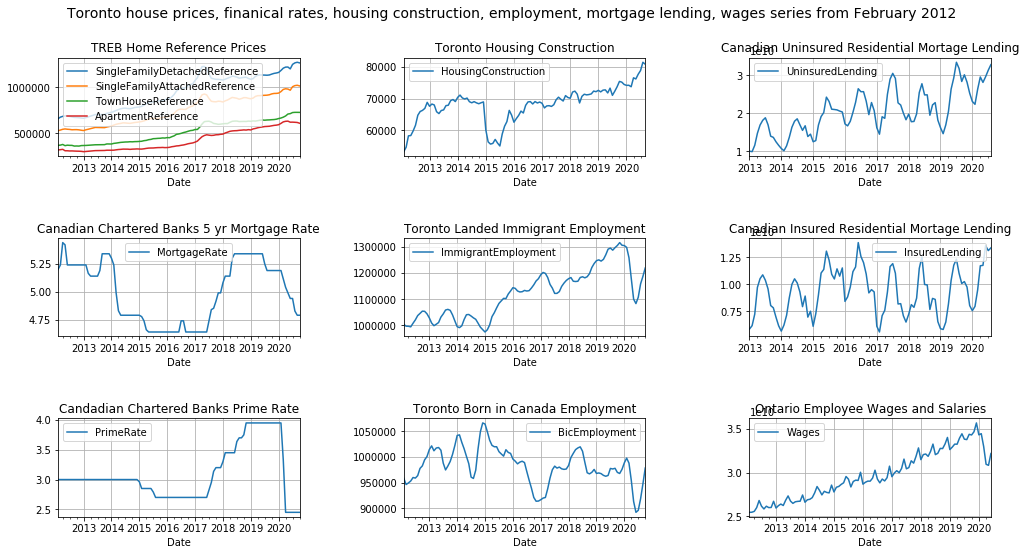

In [29]:
# plot all series together to visualize any relationships
fig, ax = plt.subplots(3,3,figsize=(15,8))
housing_price_df[reference_price_cols].plot(ax=ax[0,0], grid=True, title='TREB Home Reference Prices')
financial_mortage_df.plot(ax=ax[1,0], grid=True, title='Canadian Chartered Banks 5 yr Mortgage Rate')
financial_prime_df.plot(ax=ax[2,0], grid=True, title='Candadian Chartered Banks Prime Rate')
construction_df.plot(ax=ax[0,1], grid=True, title ='Toronto Housing Construction')
employment_bic_df.plot(ax=ax[2,1], grid=True, title='Toronto Born in Canada Employment')
employment_immigrant_df.plot(ax=ax[1,1], grid=True, title='Toronto Landed Immigrant Employment')
mortgage_uninsured_df.plot(ax=ax[0,2], grid=True, title ='Canadian Uninsured Residential Mortage Lending')
mortgage_insured_df.plot(ax=ax[1,2], grid=True, title = 'Canadian Insured Residential Mortage Lending')
wages_df.plot(ax=ax[2,2], grid=True, title='Ontario Employee Wages and Salaries')
fig.tight_layout(pad=3.5)
fig.suptitle('Toronto house prices, finanical rates, housing construction, employment, mortgage lending, wages series from February 2012', fontsize=14, y=1)

In [27]:
# select certain factors to analyze further with home prices
# Immigration Employment, UninsuredLending, Wages were selected to investigate further
house_price_factors_df = pd.concat([housing_price_df[reference_price_cols], employment_immigrant_df, mortgage_uninsured_df, wages_df],axis=1)

In [28]:
# the UninsuredLending series only starts at 2013-01 and last data point for Wages is 2020-06 
house_price_factors_df = house_price_factors_df['2013-01':'2020-06']

In [31]:
# plot correlation heat map of housing reference prices and factors of ImmigrantEmployment, UninsuredLending, Wages for period if 2013-01 to 2020-06
# these factors were chosen from the visual inspection above for further analysis
corr_df = house_price_factors_df.corr()
corr_df.style.background_gradient(cmap='coolwarm')

,SingleFamilyDetachedReference,SingleFamilyAttachedReference,TownHouseReference,ApartmentReference,ImmigrantEmployment,UninsuredLending,Wages
SingleFamilyDetachedReference,1.000000,0.993061,0.975856,0.911482,0.845540,0.715427,0.880336
SingleFamilyAttachedReference,0.993061,1.000000,0.991110,0.951472,0.864514,0.722788,0.913822
TownHouseReference,0.975856,0.991110,1.000000,0.972067,0.847503,0.715242,0.920780
ApartmentReference,0.911482,0.951472,0.972067,1.000000,0.839767,0.672650,0.926974
ImmigrantEmployment,0.845540,0.864514,0.847503,0.839767,1.000000,0.628671,0.908589
UninsuredLending,0.715427,0.722788,0.715242,0.672650,0.628671,1.000000,0.676095
Wages,0.880336,0.913822,0.920780,0.926974,0.908589,0.676095,1.000000


### Build simple baseline using Prophet generalized linear model with seasonality

In [222]:
# create predictions for SingleFamilyDetachedReference witout and with regressors
singlefamilydetached_df = house_price_factors_df[['SingleFamilyDetachedReference','ImmigrantEmployment','UninsuredLending','Wages']]

In [223]:
# create train and test dataframe
# test time frame selected fro 2019-07 to 2020-06
singlefamilydetached_train_df = singlefamilydetached_df[:'2019-6']
singlefamilydetached_test_df = singlefamilydetached_df['2019-7':]

In [224]:
# prepare train dataframe for the prophet model
singlefamilydetachted_train_prophet_df = pd.DataFrame({'ds':singlefamilydetached_train_df.index, 
                                                       'y':singlefamilydetached_train_df['SingleFamilyDetachedReference'],
                                                       })

In [225]:
# create a prophet model, turn off weekly and daily seasonality, model will look for yearly seasonality automatically
# yearly seasonality is increased over baseline to get more fitting of seasonal effects in price
# seasonality_prior_scale is reduced below baseline for more regularization on overfitting seasonality

m = Prophet(weekly_seasonality=False, daily_seasonality=False, yearly_seasonality=20, seasonality_prior_scale=2.0)

# fit the model
m.fit(singlefamilydetachted_train_prophet_df)

In [226]:
# function for mean absolute percentage error
def mape(predicted, actual):
    return round(np.mean(np.abs((predicted-actual)/actual))*100,3)

In [227]:
# create forecast dataframe from 2019-07 to 2020-06
# calculate mean absolute percentage error

singlefamilydetachted_predict_df = pd.DataFrame({'ds':singlefamilydetached_test_df.index})
singlefamilydetachted_forecast_df = m.predict(singlefamilydetachted_predict_df)
singlefamilydetachted_forecast_mape = mape(singlefamilydetachted_forecast_df['yhat'].values, singlefamilydetached_test_df['SingleFamilyDetachedReference'].values)
print('MAPE:',singlefamilydetachted_forecast_mape)

MAPE: 3.869


### Add regressors to model from investigation of different factors

In [228]:
# add regressors to the training dataframe
# prepare train dataframe for the prophet model
singlefamilydetachted_train_prophet_factors_df = pd.DataFrame({'ds':singlefamilydetached_train_df.index, 
                                                       'y':singlefamilydetached_train_df['SingleFamilyDetachedReference'],
                                                       'ImmigrantEmployment':singlefamilydetached_train_df['ImmigrantEmployment'],
                                                        'UninsuredLending':singlefamilydetached_train_df['UninsuredLending'],
                                                        'Wages':singlefamilydetached_train_df['Wages']})

In [229]:
# create a prophet model, turn off weekly and daily seasonality, model will look for yearly seasonality automatically
# yearly seasonality is increased over baseline to get more fitting of seasonal effects in price
# seasonality_prior_scale is reduced below baseline for more regularization on overfitting seasonality

m = Prophet(weekly_seasonality=False, daily_seasonality=False, yearly_seasonality=20, seasonality_prior_scale=2.0)
m.add_regressor('ImmigrantEmployment')
m.add_regressor('UninsuredLending')
m.add_regressor('Wages')

# fit the model
m.fit(singlefamilydetachted_train_prophet_factors_df)

In [230]:
# create forecast dataframe from 2019-07 to 2020-06
# calculate mean absolute percentage error
singlefamilydetachted_predict_factors_df = pd.DataFrame({'ds':singlefamilydetached_test_df.index,
                                                        'ImmigrantEmployment':singlefamilydetached_test_df['ImmigrantEmployment'],
                                                        'UninsuredLending':singlefamilydetached_test_df['UninsuredLending'],
                                                        'Wages':singlefamilydetached_test_df['Wages']})

singlefamilydetachted_forecast_factors_df = m.predict(singlefamilydetachted_predict_factors_df)
singlefamilydetachted_forecast_factors_mape = mape(singlefamilydetachted_forecast_factors_df['yhat'].values, singlefamilydetached_test_df['SingleFamilyDetachedReference'].values)
print('MAPE:',singlefamilydetachted_forecast_factors_mape)

MAPE: 2.615


### Visualization of model results

<Figure size 720x432 with 0 Axes>

Text(0.5, 1.0, 'Toronto Single Family Detached Reference Price Prediction from 2019-07 to 2020-06')

Text(0.5, 0, 'Time (monthly)')

Text(0, 0.5, 'Reference Price')

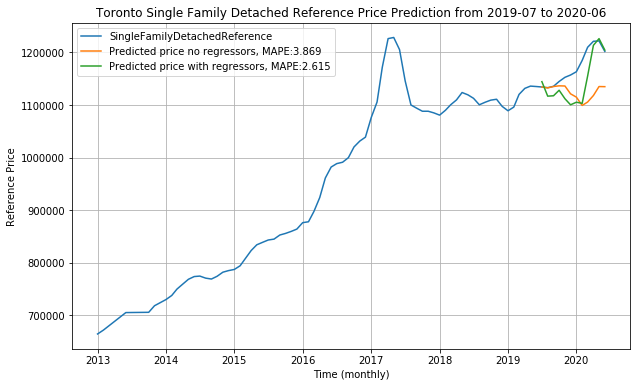

In [232]:
# plot series for single family detacehd reference price ground truth and 6 month predictions
# for baseline with no regressors and model with regressors of ImmmigrantEmployment, UninsuredLending, Wages
plt.figure(figsize=(10,6))
plt.title('Toronto Single Family Detached Reference Price Prediction from 2019-07 to 2020-06')
plt.plot(singlefamilydetached_df.index.values, singlefamilydetached_df['SingleFamilyDetachedReference'].values, label='SingleFamilyDetachedReference')
plt.plot(singlefamilydetachted_forecast_df['ds'].values, singlefamilydetachted_forecast_df['yhat'].values, label=f'Predicted price no regressors, MAPE:{singlefamilydetachted_forecast_mape}')
plt.plot(singlefamilydetachted_forecast_factors_df['ds'].values, singlefamilydetachted_forecast_factors_df['yhat'].values, label=f'Predicted price with regressors, MAPE:{singlefamilydetachted_forecast_factors_mape}')
plt.xlabel('Time (monthly)')
plt.ylabel('Reference Price')
plt.legend()
plt.grid(True)